In [2]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import glob
import math
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from torch.utils.data import (
    Dataset,
    DataLoader
)
import torch
import torchvision.transforms as transforms
from skimage import io
from transformers import ViTFeatureExtractor, ViTForImageClassification

from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification

In [3]:
basedir = os.getcwd()
datadir = basedir + '/data'

# reading the csv file with annotated image file names
train_cultivar= pd.read_csv(datadir + '/train_cultivar_mapping.csv')
train_cultivar.dropna(inplace=True)

# turning cultivar labels into strings
train_cultivar['cultivar']=train_cultivar['cultivar'].astype(str)
train_cultivar.head()

,image,cultivar
0,2017-06-16__12-24-20-930.png,PI_257599
1,2017-06-02__16-48-57-866.png,PI_154987
2,2017-06-12__13-18-07-707.png,PI_92270
3,2017-06-22__13-18-06-841.png,PI_152651
4,2017-06-26__12-56-48-642.png,PI_176766


In [4]:
# creating list of unique cultivars
labels=list(np.unique(train_cultivar['cultivar']))
labels

['PI_144134',
 'PI_145619',
 'PI_145626',
 'PI_145633',
 'PI_146890',
 'PI_152591',
 'PI_152651',
 'PI_152694',
 'PI_152727',
 'PI_152728',
 'PI_152730',
 'PI_152733',
 'PI_152751',
 'PI_152771',
 'PI_152816',
 'PI_152828',
 'PI_152860',
 'PI_152862',
 'PI_152923',
 'PI_152961',
 'PI_152965',
 'PI_152966',
 'PI_152967',
 'PI_152971',
 'PI_153877',
 'PI_154750',
 'PI_154844',
 'PI_154846',
 'PI_154944',
 'PI_154987',
 'PI_154988',
 'PI_155516',
 'PI_155760',
 'PI_155885',
 'PI_156178',
 'PI_156217',
 'PI_156268',
 'PI_156326',
 'PI_156330',
 'PI_156393',
 'PI_156463',
 'PI_156487',
 'PI_156871',
 'PI_156890',
 'PI_157030',
 'PI_157035',
 'PI_157804',
 'PI_167093',
 'PI_170787',
 'PI_175919',
 'PI_176766',
 'PI_179749',
 'PI_180348',
 'PI_181080',
 'PI_181083',
 'PI_195754',
 'PI_196049',
 'PI_196583',
 'PI_196586',
 'PI_196598',
 'PI_197542',
 'PI_19770',
 'PI_213900',
 'PI_217691',
 'PI_218112',
 'PI_221548',
 'PI_221651',
 'PI_22913',
 'PI_229841',
 'PI_251672',
 'PI_253986',
 'PI_255

In [5]:
train_cultivar["cultivar_index"] = train_cultivar["cultivar"].map(lambda item: labels.index(item))
train_cultivar

,image,cultivar,cultivar_index
0,2017-06-16__12-24-20-930.png,PI_257599,73
1,2017-06-02__16-48-57-866.png,PI_154987,29
2,2017-06-12__13-18-07-707.png,PI_92270,99
3,2017-06-22__13-18-06-841.png,PI_152651,6
4,2017-06-26__12-56-48-642.png,PI_176766,50
...,...,...,...
22189,2017-06-16__12-27-16-266.png,PI_170787,48
22190,2017-06-28__11-19-57-454.png,PI_156393,39
22191,2017-06-28__10-20-32-417.png,PI_152923,18
22192,2017-06-28__12-47-02-714.png,PI_257599,73


In [6]:
# training and validation split 80/20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_cultivar['image'],train_cultivar["cultivar_index"], test_size = 0.2)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print(X_train[0])
print(X_train[1])

2017-06-12__14-42-40-394.png
2017-06-01__11-52-19-546.png


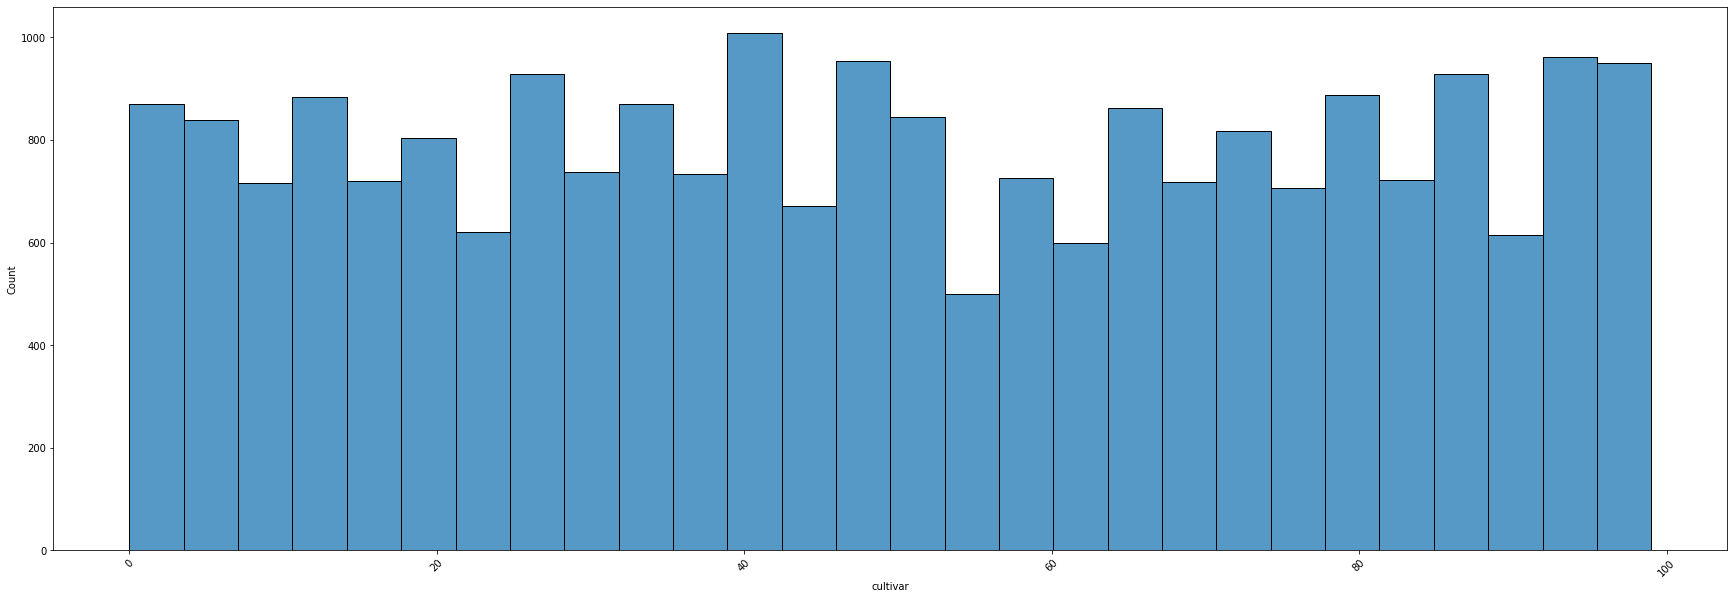

In [60]:
a=pd.DataFrame({'cultivar':train_cultivar['cultivar_index']})
plt.figure(figsize=(30,10))
sns.histplot(a,x='cultivar')
plt.xticks(rotation=45)
plt.show()

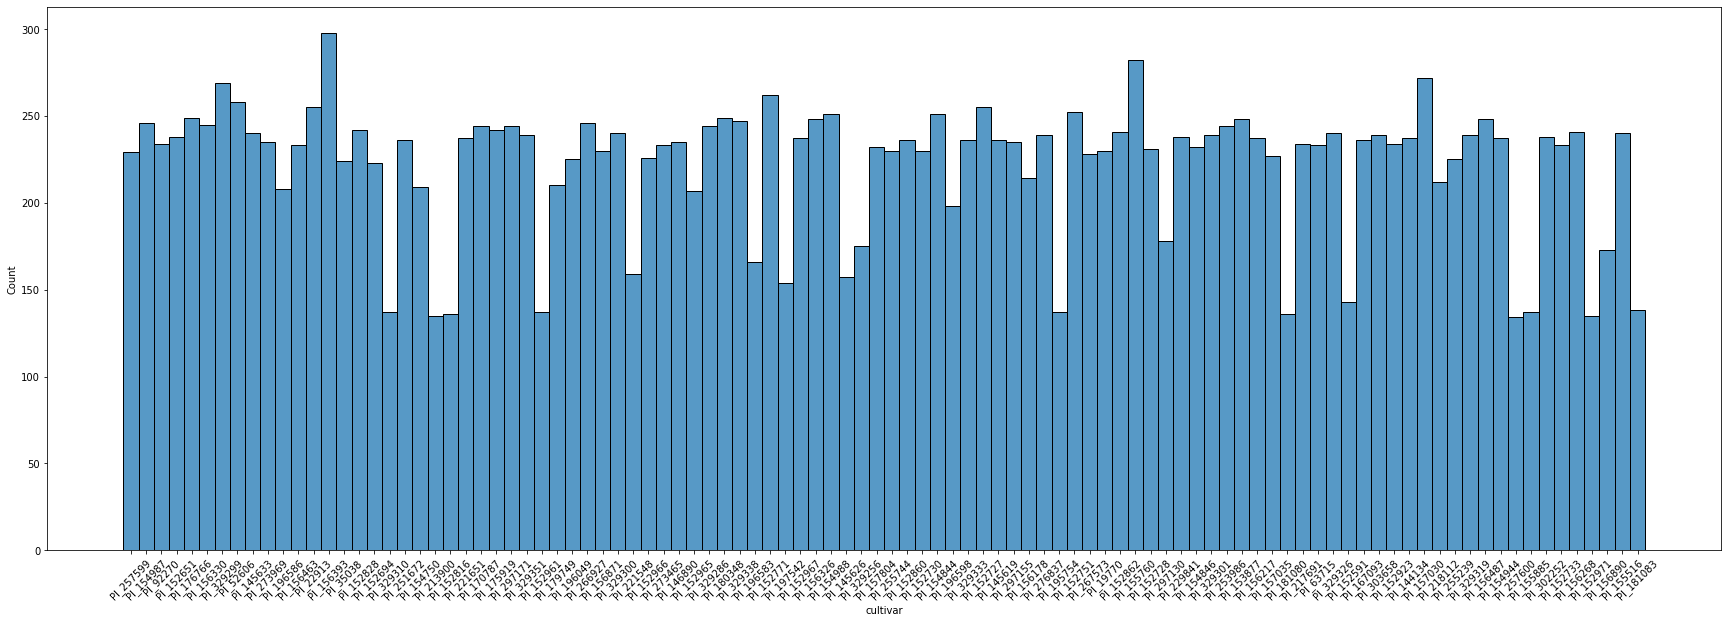

In [5]:
# visualizing frequency of cultivars 

import seaborn as sns
a=pd.DataFrame({'cultivar':train_cultivar['cultivar']})
plt.figure(figsize=(30,10))
sns.histplot(a,x='cultivar')
plt.xticks(rotation=45)
plt.show()

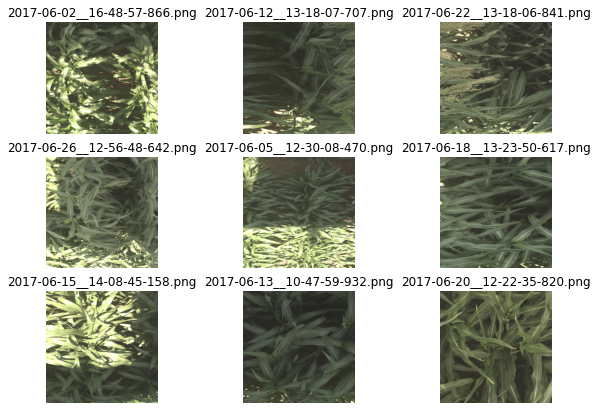

In [41]:
img_path= datadir + "/train_images"
fig = plt.figure(figsize=(10,7))
rows = 3
columns =3
for i in range(1,10):
    image=plt.imread(img_path+f"/{train_cultivar.image.values[i]}")
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title(train_cultivar.image.values[i])

In [7]:
#model_name_or_path = 'facebook/convnext-tiny-224'
#feature_extractor = ConvNextFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# building feature extractor to grab labels
class FeatureExtractor(object):
    def __call__(self, image, target):
        sample = feature_extractor(image, return_tensors='pt')
        sample["labels"] = target
        return sample

# building dataset to grab images
class CultivarDataset(Dataset):
    def __init__(self, df_img, df_label, transform):
        self.labels = df_label
        self.image_path = df_img
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = datadir + '/train_images/' + self.image_path[idx]
        image = io.imread(image_path)
        
        #y_label = torch.tensor(int(self.labels.iloc[idx]))
        y_label = int(self.labels.iloc[idx])
        
        data = self.transform(image,y_label)

        return data

In [8]:
# train dataset
train_ds = CultivarDataset(
    df_img = X_train,
    df_label = y_train,
    transform=FeatureExtractor(),
)

# valid dataset
test_ds = CultivarDataset(
    df_img = X_test,
    df_label = y_test,
    transform=FeatureExtractor(),
)

In [80]:
null = []
exist = []
for i in range(100):
    try:
        if isinstance(train_ds.__getitem__(i)['labels'],int):
            exist.append(i)
    except:
        null.append(i)
        

In [82]:
# checking to see pixel values of image
train_ds.__getitem__(9)['labels']

43

In [9]:
import numpy as np
from datasets import load_metric

# argmax finds the greatest probability and assigns label based on max probability
metric = load_metric("accuracy")
#def compute_metrics(p):
#    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [10]:
label2id, id2label = dict(), dict()
for i,label in enumerate(labels):
    label2id[label]=str(i)
    id2label[str(i)]=label

In [21]:
id2label
keys = pd.DataFrame.from_dict(id2label) 
keys.to_csv (datadir + '/keys.csv', index = False, header=True)

ValueError: If using all scalar values, you must pass an index

In [12]:
model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224",
        num_labels=len(labels),
        ignore_mismatched_sizes=True,
        id2label=id2label,
        label2id=label2id
    )

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
id2label

{'0': 'PI_144134',
 '1': 'PI_145619',
 '2': 'PI_145626',
 '3': 'PI_145633',
 '4': 'PI_146890',
 '5': 'PI_152591',
 '6': 'PI_152651',
 '7': 'PI_152694',
 '8': 'PI_152727',
 '9': 'PI_152728',
 '10': 'PI_152730',
 '11': 'PI_152733',
 '12': 'PI_152751',
 '13': 'PI_152771',
 '14': 'PI_152816',
 '15': 'PI_152828',
 '16': 'PI_152860',
 '17': 'PI_152862',
 '18': 'PI_152923',
 '19': 'PI_152961',
 '20': 'PI_152965',
 '21': 'PI_152966',
 '22': 'PI_152967',
 '23': 'PI_152971',
 '24': 'PI_153877',
 '25': 'PI_154750',
 '26': 'PI_154844',
 '27': 'PI_154846',
 '28': 'PI_154944',
 '29': 'PI_154987',
 '30': 'PI_154988',
 '31': 'PI_155516',
 '32': 'PI_155760',
 '33': 'PI_155885',
 '34': 'PI_156178',
 '35': 'PI_156217',
 '36': 'PI_156268',
 '37': 'PI_156326',
 '38': 'PI_156330',
 '39': 'PI_156393',
 '40': 'PI_156463',
 '41': 'PI_156487',
 '42': 'PI_156871',
 '43': 'PI_156890',
 '44': 'PI_157030',
 '45': 'PI_157035',
 '46': 'PI_157804',
 '47': 'PI_167093',
 '48': 'PI_170787',
 '49': 'PI_175919',
 '50': 'PI

In [14]:
model = ConvNextForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    ignore_mismatched_sizes=True,
    id2label=id2label,
    label2id=label2id
)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback
learning_rates = [5e-4, 2e-3]


training_args = TrainingArguments(
  output_dir="./results",
  logging_dir = '/home/runs',
  evaluation_strategy='steps',
  per_device_train_batch_size=64,
  num_train_epochs=4,
  save_total_limit = 4, # Only last 4 models are saved. Older ones are deleted.
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  load_best_model_at_end=True,
)

In [12]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'][0] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

Using amp half precision backend


In [90]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 17754
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 1
  Total optimization steps = 372


Step,Training Loss,Validation Loss,Accuracy
100,2.089500,2.146573,0.560937
200,1.590200,1.703572,0.653976
300,1.456100,1.591108,0.683487


/opt/conda/lib/python3.8/site-packages/transformers/trainer.py:1597: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
***** Running Evaluation *****
  Num examples = 4439
  Batch size = 24
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-100/preprocessor_config.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but a

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1666413660GF
  train_loss               =       1.8481
  train_runtime            =   1:11:23.28
  train_samples_per_second =        16.58
  train_steps_per_second   =        0.087


In [100]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 4439
  Batch size = 24
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.6835
  eval_loss               =     1.5911
  eval_runtime            = 0:03:46.23
  eval_samples_per_second =     19.621
  eval_steps_per_second   =      0.818


In [22]:
def model_init():
    return ConvNextForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    ignore_mismatched_sizes=True,
    id2label=id2label,
    label2id=label2id
)

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Using amp half precision backend
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17754
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 280
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
100,2.146400,2.195555,0.440640
200,0.802800,1.096600,0.697229


***** Running Evaluation *****
  Num examples = 4439
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-100/preprocessor_config.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 4439
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-200/preprocessor_config.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: 

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 5171071430GF
  train_loss               =       1.8715
  train_runtime            =   1:15:46.12
  train_samples_per_second =       15.621
  train_steps_per_second   =        0.062


In [16]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 4439
  Batch size = 32


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.6972
  eval_loss               =     1.0966
  eval_runtime            = 0:04:33.20
  eval_samples_per_second =     16.248
  eval_steps_per_second   =      0.509
